## Tutorial on Parallel Parcels with MPI 

Parcels can be run in Parallel with MPI. To do this, first follow the installation instructions at http://oceanparcels.org/#parallel_install.

### Splitting the ParticleSet with MPI

Once you have installed a parallel version of Parcels, you can simply run your script with

```
mpirun -np <np> python <yourscript.py>
```
Where `<np>` is the number of processors you want to use

Parcels will then split the `ParticleSet` into `<np>` smaller ParticleSets, based on a `sklearn.cluster.KMeans` clustering. Each of those smaller `ParticleSets` will be executed by one of the `<np>` MPI processors.

Note that in principle this means that all MPI processors need access to the full `FieldSet`, which can be Gigabytes in size for large global datasets. Therefore, efficient parallelisation only works if at the same time we also chunk the `FieldSet` into smaller domains

### Chunking the FieldSet with dask

The basic idea of field-chunking in Parcels is that we use the `dask` library to load only these regions of the `Field` that are occupied by `Particles`. The advantage is that if different MPI procesors take care of Particles in different parts of the domain, each only needs to load a small section of the full `FieldSet` (although note that this load-balancing functionality is still in [development](#Future-developments)). Furthermore, the field-chunking in principle makes the `indices` keyword superfluous, as Parcels will determine which part of the domain to load itself.

The default behaviour is for `dask` to control the chunking, via a call to `da.from_array(data, chunks='auto')`. The chunksizes are then determined by the layout of the NetCDF files. 

However, in tests we have experienced that this may not necessarily be the most efficient chunking. Therefore, Parcels provides control over the chunk-size via the `field_chunksize` keyword in `Field` creation, which requires a tuple that sets the typical size of chunks for each dimension.

It is strongly encouraged to explore what the best value for chunksize is for your experiment, which will depend  on the `FieldSet`, the `ParticleSet` and the type of simulation (2D versus 3D). As a guidance, we have found that chunksizes in the zonal and meridional direction of approximately `500` are typically most effective.

The below shows an example script to explore the scaling of the time taken for `pset.execute()` as a function of zonal and meridional `field_chunksize` for a dataset from the [CMEMS](http://marine.copernicus.eu/) portal.

In [1]:
%pylab inline
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4
from datetime import timedelta as delta
import numpy as np
from glob import glob
import time
import matplotlib.pyplot as plt

def set_cmems_fieldset(cs):
    files = sorted(glob('/Users/erik/Desktop/CMEMSdata_tmp/mercatorglorys12v1_gl12_mean_201607*.nc'))
    variables = {'U': 'uo', 'V': 'vo'}
    dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}

    if cs not in ['auto', False]:
        cs = (1, cs, cs)
    return FieldSet.from_netcdf(files, variables, dimensions, field_chunksize=cs)

func_time = []
chunksize = [50, 100, 200, 400, 800, 1000, 1500, 2000, 2500, 4000, 'auto', False]
for cs in chunksize:
    
    fieldset = set_cmems_fieldset(cs)
    pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=[0], lat=[0], repeatdt=delta(hours=1))

    tic = time.time()
    pset.execute(AdvectionRK4, dt=delta(hours=1))
    func_time.append(time.time()-tic)


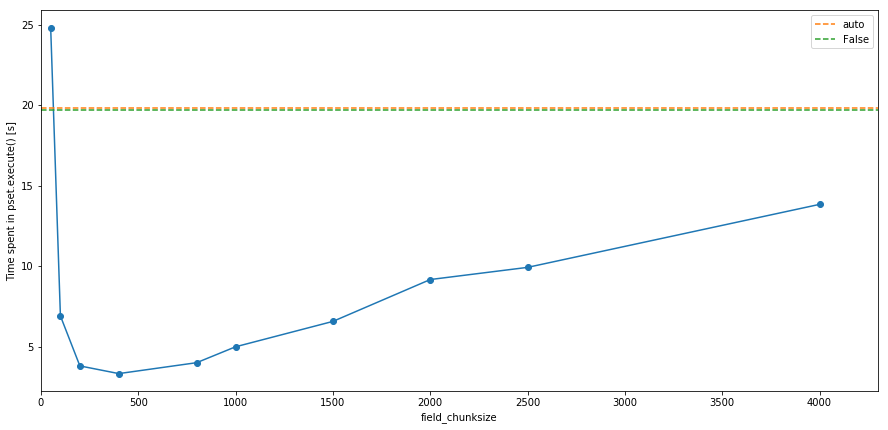

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7)) 

ax.plot(chunksize[:-2], func_time[:-2], 'o-')
ax.plot([0, 4300], [func_time[-2], func_time[-2]], '--', label=chunksize[-2])
ax.plot([0, 4300], [func_time[-1], func_time[-1]], '--', label=chunksize[-1])
plt.xlim([0, 4300])
plt.legend()
ax.set_xlabel('field_chunksize')
ax.set_ylabel('Time spent in pset.execute() [s]')
plt.show()

The plot above shows that in this case, `field_chunksize='auto'` and `field_chunksize=False` (the two dashed lines) are roughly the same speed, but that the fastest run is for `field_chunksize=(1, 400, 400)`. 

Important to note is that for small chunksize (`field_chunksize=(1, 50, 50)` in this case), the execution time is actually _longer_ than for no chunking at all, due to `dask` overhead. But this again will depend on the `FieldSet` used and the specifics of your experiment.

Also note that this is for a 2D application. For 3D applications, the `field_chunksize=False` will almost always be slower than `field_chunksize='auto'` or any tuple. That can be seen in the plot below, which shows the same analysis but then for a set of simulations using the full 3D CMEMS code. In this case, the `field_chunksize='auto'` is about a factor 100(!!) faster than running without chunking. But choosing too small chunksizes can make the code even slower, again highlighting that it is wise to explore which chunksize is best for your experiment before you perform it.

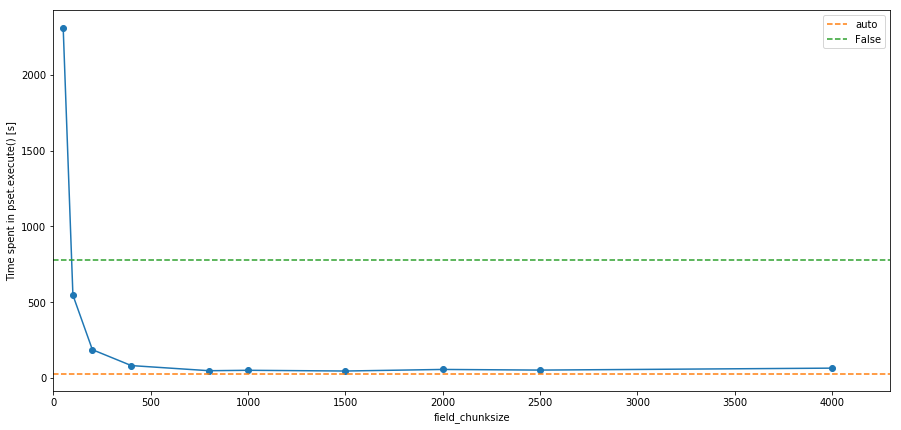

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7)) 

ax.plot(chunksize[:-2], func_time3D[:-2], 'o-')
ax.plot([0, 4300], [func_time3D[-2], func_time3D[-2]], '--', label=chunksize[-2])
ax.plot([0, 4300], [func_time3D[-1], func_time3D[-1]], '--', label=chunksize[-1])
plt.xlim([0, 4300])
plt.legend()
ax.set_xlabel('field_chunksize')
ax.set_ylabel('Time spent in pset.execute() [s]')
plt.show()

### Future developments: load-balancing

The current implementation of MPI parallelisations in Parcels is still fairly rudimentary. In particular, we will continue to develop the load-balancing of the `ParticleSet`.

With load-balancing we mean that `Particles` that are close together are ideally on the same MPI processor. Practically, it means that we need to take care how `Particles` are spread over chunks and processors. See for example the two figures below:

![](http://oceanparcels.org/images/parcelsParallel.png)
*Example of load-balancing for Particles. The domain is chunked along the thick lines, and the orange and blue particles are on separate MPI processors. Before load-balancing (left panel), two chuncks in the centre of the domain have both orange and blue particles. After the load-balancing (right panel), the Particles are redistributed over the processors so that the number of chunks and particles per processor is optimised.*

The difficulty is that since we don't know how the `ParticleSet` will disperse over time, we need to do this load-balancing 'on the fly'. If you to contribute to the optimisation of the load-balancing, please leave a message on [github](https://github.com/OceanParcels/parcels/issues)!